In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import os
import random
import argparse
import time
import cv2

In [12]:
# Load and preprocess data
train_data = np.load('dataset/train.npz')
X_train, y_train = train_data['images'], train_data['labels']
test_data = np.load('dataset/test.npz')
X_test, y_test = test_data['images'], test_data['labels']

# Resize and normalize data
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),  # Ensure consistent input size
    transforms.ToTensor()         # Normalize and transpose to (C, H, W)
])

X_train = np.array([transform(img).numpy() for img in X_train])
X_test = np.array([transform(img).numpy() for img in X_test])

# Convert to PyTorch tensors
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=64, shuffle=True)
test_loader = DataLoader(list(zip(X_test, y_test)), batch_size=64, shuffle=False)


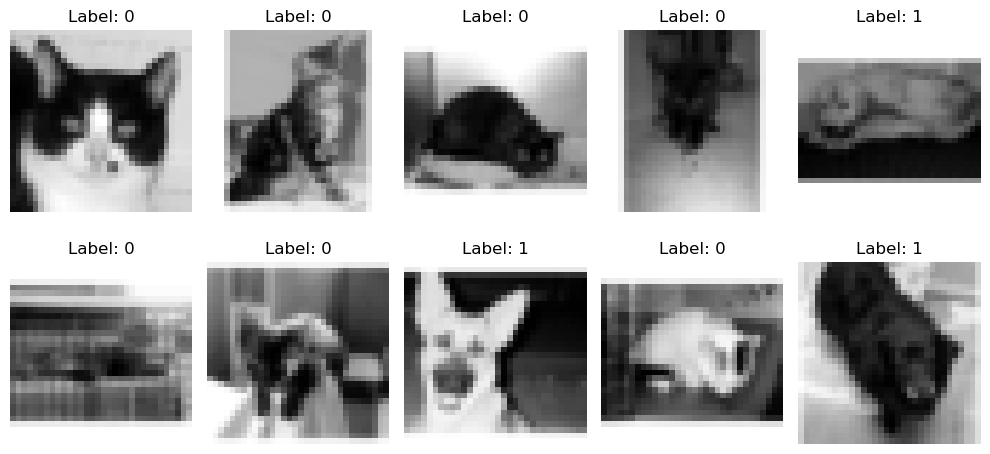

In [13]:
# plot some images
def plot_images(images, labels, num_images=10):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).numpy(), cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(X_train, y_train, num_images=10)

In [34]:
class CNN(nn.Module):
    def __init__(self, input_channels=1, input_size=(32, 32), num_classes=2, dropout_rate=0.5):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_channels, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
        )

        test_input = torch.randn(1, 1, input_size[0], input_size[1])
        output_size = self.layer3(self.layer2(self.layer1(test_input))).numel()
        
        self.fc1 = nn.Linear(output_size, 625, bias=True)

        self.layer4 = nn.Sequential(
            self.fc1,
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
        )

        self.fc2 = nn.Linear(625, num_classes, bias=True)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.layer4(x)
        x = self.fc2(x)
        return x

In [35]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    # print(f'Train Epoch: {epoch} Loss: {train_loss:.6f} Accuracy: {correct}/{len(train_loader.dataset)} ({100. * correct / len(train_loader.dataset):.0f}%)')
    return train_loss, 100. * correct / len(train_loader.dataset)

In [36]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    # print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)')
    return test_loss, 100. * correct / len(test_loader.dataset)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.0108, Train Accuracy: 55.73%, Test Loss: 0.0108, Test Accuracy: 57.28%
Epoch 2: Train Loss: 0.0105, Train Accuracy: 59.00%, Test Loss: 0.0107, Test Accuracy: 57.60%
Epoch 3: Train Loss: 0.0102, Train Accuracy: 61.66%, Test Loss: 0.0106, Test Accuracy: 62.66%
Epoch 4: Train Loss: 0.0100, Train Accuracy: 63.73%, Test Loss: 0.0105, Test Accuracy: 58.20%
Epoch 5: Train Loss: 0.0098, Train Accuracy: 64.82%, Test Loss: 0.0103, Test Accuracy: 62.16%
Epoch 6: Train Loss: 0.0097, Train Accuracy: 65.44%, Test Loss: 0.0103, Test Accuracy: 61.60%
Epoch 7: Train Loss: 0.0096, Train Accuracy: 66.60%, Test Loss: 0.0102, Test Accuracy: 62.32%
Epoch 8: Train Loss: 0.0095, Train Accuracy: 67.21%, Test Loss: 0.0100, Test Accuracy: 66.26%
Epoch 9: Train Loss: 0.0093, Train Accuracy: 67.97%, Test Loss: 0.0098, Test Accuracy: 65.02%
Epoch 10: Train Loss: 0.0091, Train Accuracy: 69.58%, Test Loss: 0.0097, Test Accuracy: 66.62%
Epoch 11: Train Loss: 0.0089, Train Accuracy: 69.96%, Test 

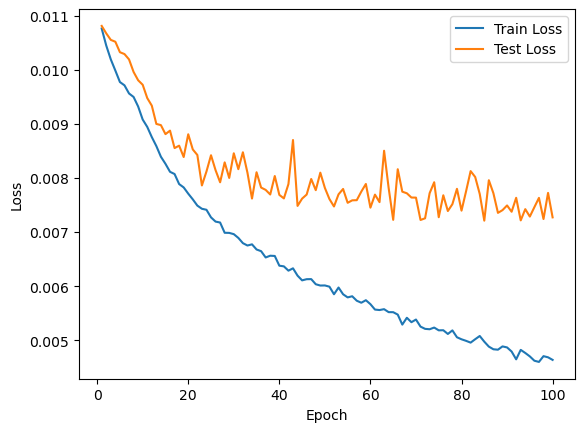

In [37]:
# Hyperparameters
bs = 64
epochs = 100
    
use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()
torch.manual_seed(1)
device = torch.device("cuda" if use_cuda else 'mps' if use_mps else "cpu")


model = CNN(num_classes=2, dropout_rate=0.5).to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()


train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
for epoch in tqdm(range(1, epochs + 1)):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, criterion, epoch)
    test_loss, test_accuracy = test(model, device, test_loader, criterion)
    tqdm.write(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)

# Plot and save loss curves
plt.figure()
plt.plot(range(1, epochs + 1), train_loss_list, label='Train Loss')
plt.plot(range(1, epochs + 1), test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('loss.png')
plt.show()